<center>

<h1 style="text-align:center"> (Side) Effects </h1>
<h2 style="text-align:center"> CS3100 Monsoon 2020 </h2>
</center>

## Why Side Effects

* We have only used **purely functional** feature of OCaml
* Our study of lambda calculus used only **purely functional** features

* The above statements are *lies*.
  + We have used `print_endline`, `printf` and other features to display our results to screen.
* It is sometimes useful to write programs that have **side effects**

## Side effects

Side effects include

* Mutating (i.e., destructively updating) the values of program state. 
* Reading from standard input, printing to standard output.
* Reading and writing to files, sockets, pipes etc.
* ...
* Composing, sending and receiving emails, editing documents, writing this slide, etc.

## Side effects in OCaml

* OCaml programs can include side effects
* Features
  + Mutations: Reference cells, Arrays, Mutable record fields
  + I/O of all sorts
* In this lecture, **Mutations**

$
\require{color}
\newcommand{\cpurple}[1]{{\color{\purple}{\text{#1}}}}
\newcommand{\cred}[1]{{\color{\red}{\text{#1}}}}
$

## Reference cells

* Aka "refs" or "ref cell"
* Pointer to a typed location in memory
* The binding of a variable to a ref cell is $\cpurple{immutable}$ 
  + but the contents of the ref cell may $\cred{change}$.

## Reference cells

Allocate new ref cells with `ref`

In [ ]:
let r = ref 0

Update using `:=` and read using `!`

In [ ]:
r := !r + 1;
!r

## Reference Cells: Types

In [ ]:
ref

In [ ]:
(!)

In [ ]:
(:=)

## Implementing a counter

In [ ]:
let make_counter init =
  let c = ref init in
  fun () -> 
    (c := !c + 1; !c)

In [ ]:
let next = make_counter 0

In [ ]:
next()

## Side effects make reasoning hard

* **Referential transparency** allows replacing $e$ with $v$ if $e =_{\beta} v$.
* Side effects break referential transparency.

## Referential transparency

Consider the function `foo`:

In [ ]:
let foo x = x + 1

In [ ]:
let baz = foo 10

`baz` can now be optimised to

In [ ]:
let baz = 11

## Referential transparency

Consider the function `bar`:

In [ ]:
let bar x = x + next()

In [ ]:
let qux = bar 10

Can we now optimise `qux` to:

In [ ]:
let qux = 19

**NO!** Referential transparency breaks under side effects. 

## Aliases

References may create aliases.

What is the result of this program?

In [ ]:
let x = ref 10 in
let y = ref 10 in
let z = x in (* XXX *)
z := !x + 1;
!x + !y

<center>
    
<img src="heap2.svg" width="350">
</center>

* Variables `z` and `x` are said to be **aliases**
  + They refer to the same object in the program heap.

## Equality

* The `=` that we have been using is known as **structural equality**
  + Checks whether the values' structurally equal. 
  + `[1;2;3] = [1;2;3]` evaluates to `true`. 
* Because of references, one may also want to ask whether two expressions are **aliases**
  + This equality is known as **physical equality**.
  + OCaml uses `==` to check for physical equality.

## Equality : Types

In [ ]:
(=)

In [ ]:
(==)

## Equality : Quiz
```ocaml
let l1 = [1;2;3];; 
let l2 = l1;; 
let l3 = [1;2;3];;
let r1 = ref l1;;
let r2 = r1;;
let r3 = ref l3;;
```
which of the following are true?

(1)`l1 = l2` (2)`l1 = l3` (3)`r1 == r2` (4)`l1 == l2` (5) `l1 = [1;2;3]`

(6) `l1 == [1;2;3]` (7) `r1 == r3` (8) `l1 == l3` (9) `r1 = r2` (10) `r1 = r3`

## Equality : Quiz

In [1]:
let l1 = [1;2;3];; 
let l2 = l1;; 
let l3 = [1;2;3];;
let r1 = ref l1;;
let r2 = r1;;
let r3 = ref l3;;

val l1 : int list = [1; 2; 3]


val l2 : int list = [1; 2; 3]


val l3 : int list = [1; 2; 3]


val r1 : int list ref = {contents = [1; 2; 3]}


val r2 : int list ref = {contents = [1; 2; 3]}


val r3 : int list ref = {contents = [1; 2; 3]}


## Equality


<center>
    <table>
        <tr>
            <td> 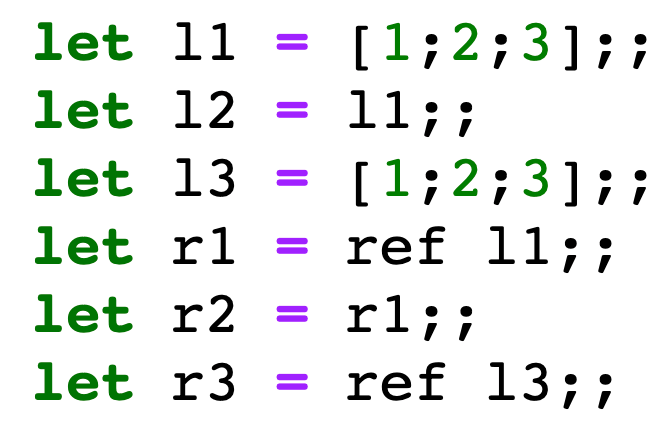 </td>
            <td> <img src="heap.svg" width="250"> </td>
        </tr>
    </table>
</center>

which of the following are true?

(1)`l1 = l2` (2)`l1 = l3` (3)`r1 == r2` (4)`l1 == l2` (5) `l1 = [1;2;3]`

(6) `l1 == [1;2;3]` (7) `r1 == r3` (8) `l1 == l3` (9) `r1 = r2` (10) `r1 = r3`

References are structurally equal iff their contents are structurally equal.

In [4]:
l1 = l2

- : bool = true


## Value Restriction

Consider the following program:

In [5]:
let r = [] in
let r1 : int list = r in
let r2 : string list = r in
(r1,r2)

- : int list * string list = ([], [])


`r` has type `'a list`. But otherwise, nothing surprising here.

## Value Restriction

Consider a modified program:

In [6]:
let r = ref [] in
let r1 : int list ref = r in
let r2 : string list ref = r in
(r1,r2)

error: compile_error

## Value Restriction

Let's look at the type of `ref []`

In [ ]:
let r = ref []

* The `'_weak1` says that `r` is only *weakly polymorphic*. 
  + `r` can be used with only one type.
  + This is known as **value restriction**.
* But why does value restriction exist?

## Why does value restriction exist?

If value restriction does not exist, the following program would be well-typed.


```ocaml
let r = ref [] in
let r1 : int list ref = r in
let r2 : string list ref = r in
r1 := [1];
print_endline (List.hd !r2)
```

* We are storing an int list in `r1` and reading it out as a string list through `r2`.
* In OCaml, value restriction is implemented as a syntactic check of RHS of let + some typing checks.
  + Details are beyond the scope of this course. 

## Partial Application and Value restriction 

Since value restriction is implemented as a syntactic check, it can sometimes be restrictive. 

For example, here is a function that swaps the elemenents of a pair in a list of pairs.

In [7]:
let swap_list = List.map (fun (a,b) -> (b,a))

val swap_list : ('_weak1 * '_weak2) list -> ('_weak2 * '_weak1) list = <fun>


The type inferred is a weakly polymorphic type.

In [8]:
(swap_list [(1,"hello")], 
 swap_list [(1,1)])

error: compile_error

## Partial Application and Value restriction 

In many cases, the unnecessary value restriction can be fixed by $\eta$ expansion. 

In [9]:
let swap_list l = List.map (fun (a,b) -> (b,a)) l

val swap_list : ('a * 'b) list -> ('b * 'a) list = <fun>


In [10]:
(swap_list [(1,"hello")], 
 swap_list [(1,1)])

- : (string * int) list * (int * int) list = ([("hello", 1)], [(1, 1)])


## Mutable Record Fields

Ref cells are essentially syntactic sugar over **mutable record fields**.

```ocaml
type 'a ref = { mutable contents: 'a }
let ref x = { contents = x }
let ( ! ) r = r.contents
let ( := ) r newval = r.contents <- newval
```

* That type is declared in `Pervasives`
* The functions are compiled down to something equivalent

## Doubly-linked list

In [11]:
(* The type of elements *)
type 'a node = { 
  value : 'a;
  mutable next : 'a node option;
  mutable prev : 'a node option
}

(* The type of list *)
type 'a dllist = 'a node option ref

type 'a node = {
  value : 'a;
  mutable next : 'a node option;
  mutable prev : 'a node option;
}


type 'a dllist = 'a node option ref


## Double-linked list

In [17]:
let create () : 'a dllist = ref None
let first (t : 'a dllist) = !t
let is_empty (t : 'a dllist) = !t = None

let value node = node.value
let next node = node.next
let prev node = node.prev

val create : unit -> 'a dllist = <fun>


val first : 'a dllist -> 'a node option = <fun>


val is_empty : 'a dllist -> bool = <fun>


val value : 'a node -> 'a = <fun>


val next : 'a node -> 'a node option = <fun>


val prev : 'a node -> 'a node option = <fun>


## Doubly-linked list

In [26]:
(* [insert_first t v] inserts a new node [n] with value [v] 
   as the first node in the list [t]. Returns [n]. *)
let insert_first (t : 'a dllist) v =
  let n = { prev = None; next = !t; value = v} in
  begin match !t with
  | Some old_first -> old_first.prev <- Some n
  | None -> ()
  end;
  t := Some n;
  n

val insert_first : 'a dllist -> 'a -> 'a node = <fun>


## Doubly-linked list

In [27]:
(* [insert_after n v] inserts a new node [n'] whose value 
   is [v] after the node [n]. Returns [n']. *)
let insert_after n v =
  let n' = { value = v; prev = Some n; next = n.next } in
  begin match n.next with
  | Some old_next -> old_next.prev <- Some n'
  | None -> ()
  end;
  n.next <- Some n';
  n'

val insert_after : 'a node -> 'a -> 'a node = <fun>


## Doubly-linked list

In [29]:
(* [remove t n] removes the node [n] from the list [t] *)
let remove (t:'a dllist) n =
  let { prev; next; _ } = n in
  begin match prev with
  | Some prev -> prev.next <- next
  | None -> t := next
  end;
  begin match next with
  | Some next -> next.prev <- prev;
  | None -> ()
  end;
  n.prev <- None;
  n.next <- None

val remove : 'a dllist -> 'a node -> unit = <fun>


## Doubly-linked list

In [31]:
(* [iter t f] applies [f] on each value in the list 
   from list to right *)
let iter (t : 'a dllist) (f : 'a -> unit) =
  let rec loop = function
    | None -> ()
    | Some el -> f (value el); loop (next el)
  in
  loop !t

val iter : 'a dllist -> ('a -> unit) -> unit = <fun>


## Doubly-linked list

In [32]:
let l = create ();;
let n0 = insert_first l 0;;
let n1 = insert_after n0 1;;
insert_after n1 2

val l : '_weak3 dllist = {contents = None}


val n0 : int node = {value = 0; next = None; prev = None}


val n1 : int node =
  {value = 1; next = None;
   prev = Some {value = 0; next = Some <cycle>; prev = None}}


- : int node =
{value = 2; next = None;
 prev =
  Some
   {value = 1; next = Some <cycle>;
    prev = Some {value = 0; next = Some <cycle>; prev = None}}}


## Doubly-linked list

In [33]:
iter l (Printf.printf "%d\n%!")

0
1
2


- : unit = ()


## Arrays

Collection type with efficient random access.

In [34]:
let a = [| 1;2;3 |]

val a : int array = [|1; 2; 3|]


Array elements are retrieved using `a.(i)` syntax where `a` is the array and `i` is the index.

In [39]:
a.(0)

- : int = 1


Arrays bounds are checked at access.

In [35]:
a.(3)

error: runtime_error

## Arrays

Array can be updated with `<-` syntax.

In [36]:
a.(1) <- 0; 
a

- : int array = [|1; 0; 3|]


In [38]:
a.(1)

- : int = 0


* Arrays behave very similar to arrays in C
 + See [Array module](https://caml.inria.fr/pub/docs/manual-ocaml/libref/Array.html) documentation in the OCaml standard library

## Benefits of immutability

* Programmer doesn’t have to think about aliasing
    + can concentrate on other aspects of code
* Language implementation is free to share objects on the heap, which is cheap
* Often easier to reason about whether code is correct
* Perfect fit for concurrent programming

But

* Some data structures (hash tables, arrays, ...) are more efficient if imperative

Recommendation

* Use immutable data structures unless performance can't be compromised

<center>

<h1 style="text-align:center"> Fin. </h1>
</center>